In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data,
    mean_min_loss,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1
rng = np.random.default_rng(random_seed)

In [37]:
# EXAMPLE 1
sde_gamma = .5
sde_beta = 10

def true_drift(x):
    x = np.atleast_2d(x)
    v = x[:,0]
    x = x[:,1]
    result = (-x**3 - x - sde_gamma * v)
    return result.reshape(-1, 1)

def true_diffusion(x):
    x = np.atleast_2d(x)
    result = np.dot(x, np.array([0, 0])) + np.sqrt(2 * sde_gamma / sde_beta)
    return result.reshape(-1, 1)

def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)

vlim = np.array([[-2.5, 2.5]])
xlim = np.array([[-2.5, 2.5]])

# NOTE: we are artificially using "symplectic" Euler here by considering "x_data" as "x(n+1)", not "x(n)"
# However, in "sample_data" x_data is sampled at random anyway, so no changes must be made inside the method.
# Note that in histogram trajectory generation, we generate using x(n+1) = x(n) + h*v(n).

x_data, y_data, p_data = sample_data(true_drift_diffusion, step_size,
                             n_pts, n_subsample, rng, vlim, plim=xlim)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 1)


In [38]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=20,
                                M_max=200,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [39]:
# calculate theoretical mean min loss (integral over loss function)
mean_min_loss(true_diffusion, n_pts, validation_split, step_size, vlim, plim=xlim)


Theoretical mean min loss: -2.0349391062863957
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


drift epoch: 53


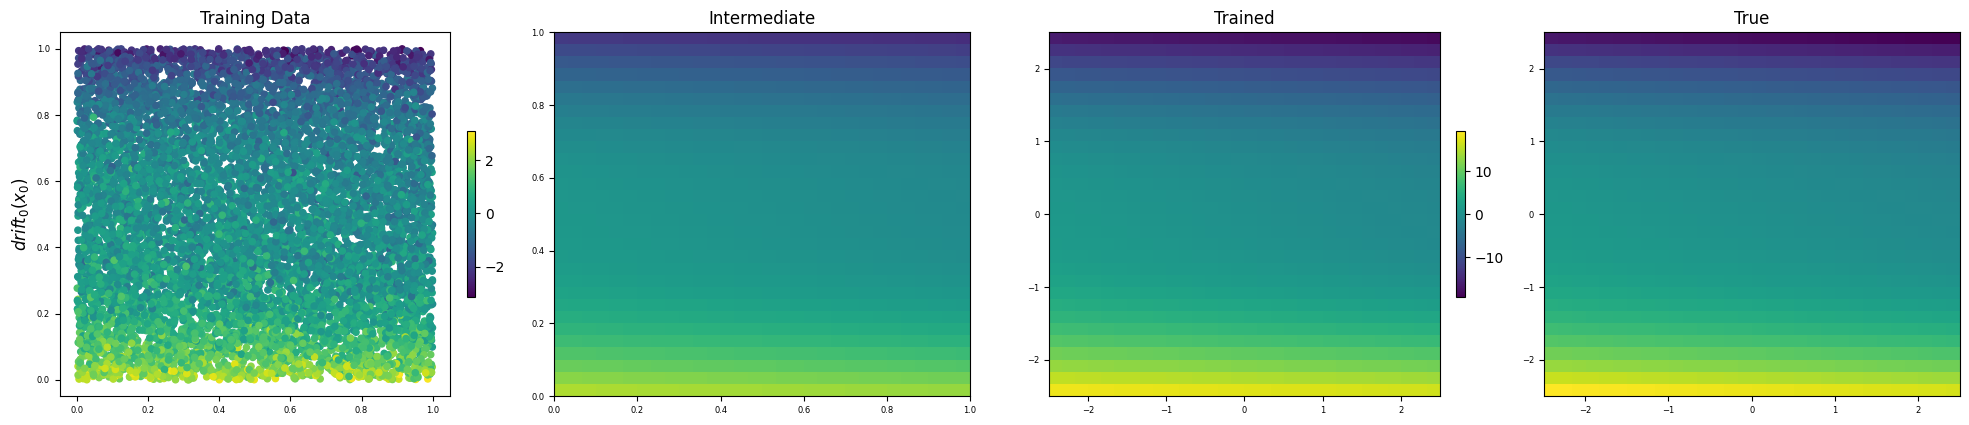

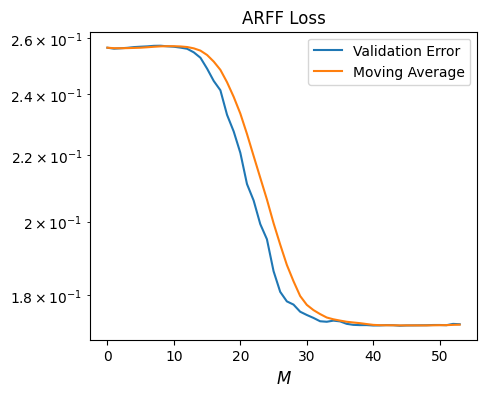

diff epoch: 20


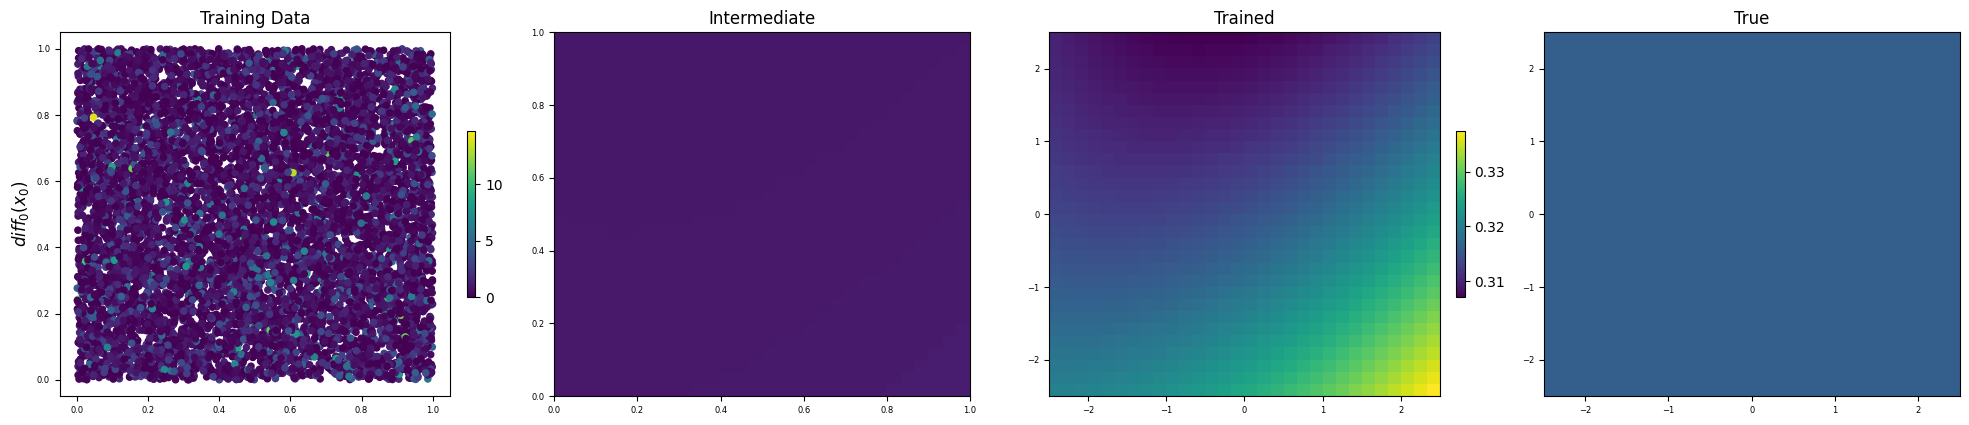

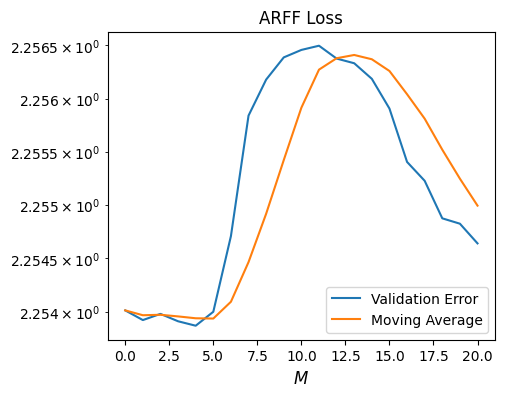

Observed loss: -2.03192403255185
Observed validation loss: -2.0286636313996773
True function validation loss: -2.0296654085739387
Training time: 7.478114604949951


In [40]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, p_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

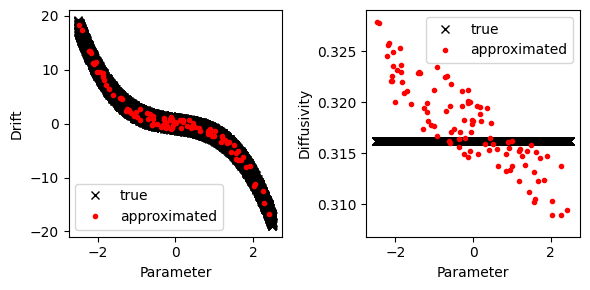

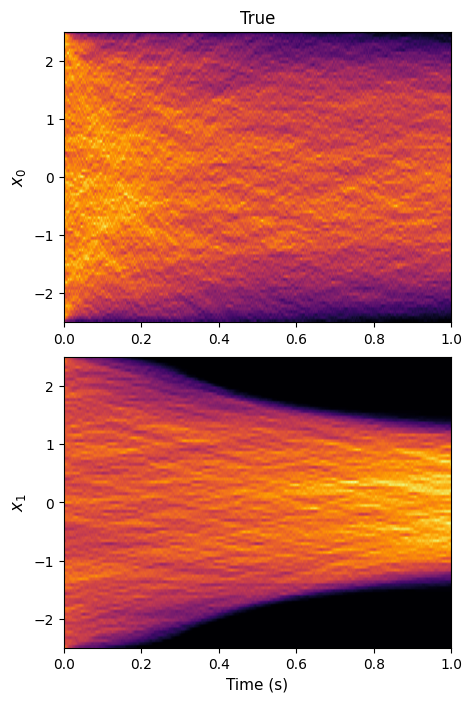

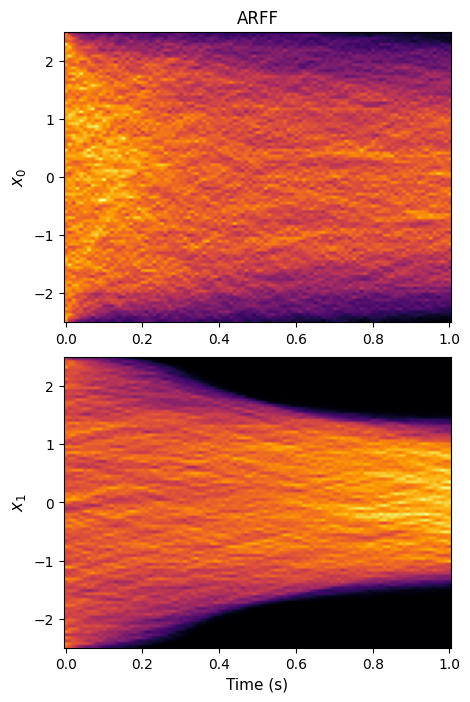

In [34]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_parameter_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, p_data, save=False)

def coupled_func(x, p, step_size):
    return p + x*step_size

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, vlim, plim=xlim, coupled_func=coupled_func, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, vlim, plim=xlim, coupled_func=coupled_func, name='ARFF', save=False)
